# Data Science Fundamentals Project

The dataset that we've selected for this project is a dataset regarding superconductivity available on both the UCI machine learning repository as well as Kaggle. <br> Link to UCI : https://archive.ics.uci.edu/dataset/464/superconductivty+data 
<br> Link to Kaggle : https://www.kaggle.com/c/superconductivity/overview
<br>

<b>(to insert here explanation of why we've selected this dataset and how it fits in our domain)</b>

The questions that we aim to answer with this project are: <br><br>

Q. What kind of machine learning model performs best in predicting the critical temperature of superconducting materials based on physicochemical descriptors?

- Supervised regression models such as Random Forest, Gradient Boosting (e.g., XGBoost), and neural networks have been commonly used in recent studies, with ensemble models frequently outperforming linear methods due to their ability to capture nonlinear feature interactions.
- Model performance is typically evaluated using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R², with deep learning models showing particular promise when trained with feature-engineered datasets and sufficient data volume.
- Comparative benchmarking studies indicate that tree-based ensemble models (e.g., XGBoost, LightGBM) and deep neural networks consistently achieve lower prediction errors than traditional models (e.g., linear regression, SVR), especially when incorporating domain-specific features like electron affinity, valence electron concentration, and weighted atomic mass.

Q. How do specific elemental properties, such as electronegativity and electronic concentration of constituent elements, quantitatively influence the critical temperature of superconducting materials?
- Recent machine learning studies show that features derived from electronic properties—particularly electronegativity and electron concentration—exhibit strong correlations with the critical temperature of superconductors.
- The importance of these properties is linked to the electronic orbitals involved, notably the 3s and 3p orbitals, which influence superconducting behavior.
- Earlier research also indicates that valence-electron numbers and electronegativity are key factors affecting critical temp

Q. Does the average valence electron concentration in superconducting materials exhibit a characteristic peak or optimal range that maximizes the critical temperature, consistent with Matthias' empirical correlation?
- Matthias' empirical correlation between valence electron concentration and critical temperature has been revisited in recent data-driven studies, which confirm a strong correlation between electron concentration and critical temperature.
- Machine learning models highlight electron concentration as a pivotal feature influencing critical temperature, supporting the existence of a characteristic range where critical temperature is maximized.
- Historical and modern analyses suggest that valence electron count is a significant descriptor in predicting superconducting properties

Q. For superconductors with critical temperatures below a certain threshold, is there a statistically significant inverse relationship between the atomic mass of constituent elements and the critical temperature, consistent with the isotope effect predicted by BCS theory?
- The isotope effect, as observed by Maxwell and Reynolds et al. in 1950, demonstrates that the critical temperature inversely depends on the isotopic mass of the elements, consistent with BCS theory.
- This inverse relationship is particularly evident in conventional superconductors with relatively low critical temperature, where heavier isotopes lead to lower critical temperatures.
- Thermodynamic and semiclassical theories further support this mass dependence through the isotope effect on phonon-mediated Cooper pairing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

There are two files : <b>"train.csv"</b> and <b>"unique_m.csv".</b>
- <b> train.csv </b> contains the number of elements, mean, geometric mean, standard deviation, weighted standard deviation, entropy, weighted entropy, range of various properties such as the fusion heat, number of valence electrons, thermal conductivity etc of the elements present in each superconductor. It also contains the critical temperature.
- <b> unique_m </b> contains chemical formula and the columns for 86 elements indicating the quantity present (as relative number of atoms) in the superconductor.

In [6]:
df = pd.read_csv("train.csv")
elements = pd.read_csv("unique_m.csv")

In [7]:
df["chemical_formula"] = elements["material"]

In [8]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,chemical_formula
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0,Ba0.3La1.7Cu1O4


In [9]:
elements.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [10]:
print("Shape of the dataset:", df.shape)
print("\nColumn Types and Non-Null Counts:")
print(df.info())

Shape of the dataset: (21263, 83)

Column Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie   

In [11]:
print("Shape of the dataset:", df.shape)
print("\nColumn Types and Non-Null Counts:")
print(elements.info())

Shape of the dataset: (21263, 83)

Column Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              21263 non-null  float64
 1   He             21263 non-null  int64  
 2   Li             21263 non-null  float64
 3   Be             21263 non-null  float64
 4   B              21263 non-null  float64
 5   C              21263 non-null  float64
 6   N              21263 non-null  float64
 7   O              21263 non-null  float64
 8   F              21263 non-null  float64
 9   Ne             21263 non-null  int64  
 10  Na             21263 non-null  float64
 11  Mg             21263 non-null  float64
 12  Al             21263 non-null  float64
 13  Si             21263 non-null  float64
 14  P              21263 non-null  float64
 15  S              21263 non-null  float64
 16  Cl             21263 non-

In [12]:
print("\nMissing Values in Each Column:")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values in Each Column:
number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
critical_temp            0
chemical_formula         0
Length: 83, dtype: int64


In [13]:
print("\nStatistical summary:")
print(df.describe())


Statistical summary:
       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000

In [14]:
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


<b> Since there's no duplpicate rows maybe we don't need this next part</b>

In [16]:
# Find and display all duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Show all duplicated rows
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(duplicates)

Empty DataFrame
Columns: [number_of_elements, mean_atomic_mass, wtd_mean_atomic_mass, gmean_atomic_mass, wtd_gmean_atomic_mass, entropy_atomic_mass, wtd_entropy_atomic_mass, range_atomic_mass, wtd_range_atomic_mass, std_atomic_mass, wtd_std_atomic_mass, mean_fie, wtd_mean_fie, gmean_fie, wtd_gmean_fie, entropy_fie, wtd_entropy_fie, range_fie, wtd_range_fie, std_fie, wtd_std_fie, mean_atomic_radius, wtd_mean_atomic_radius, gmean_atomic_radius, wtd_gmean_atomic_radius, entropy_atomic_radius, wtd_entropy_atomic_radius, range_atomic_radius, wtd_range_atomic_radius, std_atomic_radius, wtd_std_atomic_radius, mean_Density, wtd_mean_Density, gmean_Density, wtd_gmean_Density, entropy_Density, wtd_entropy_Density, range_Density, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity, wtd_mean_ElectronAffinity, gmean_ElectronAffinity, wtd_gmean_ElectronAffinity, entropy_ElectronAffinity, wtd_entropy_ElectronAffinity, range_ElectronAffinity, wtd_range_ElectronAffinity, std_Electron

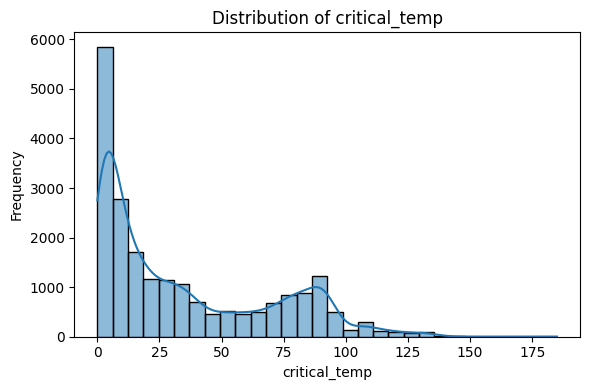

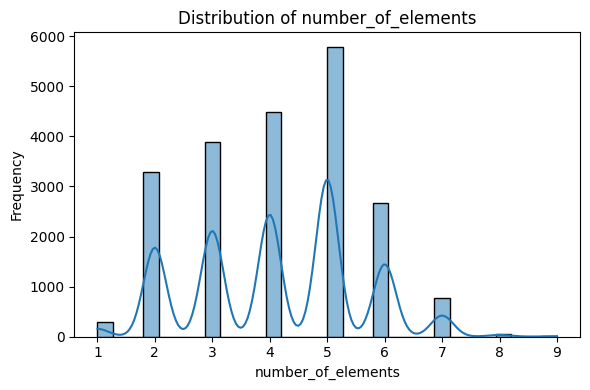

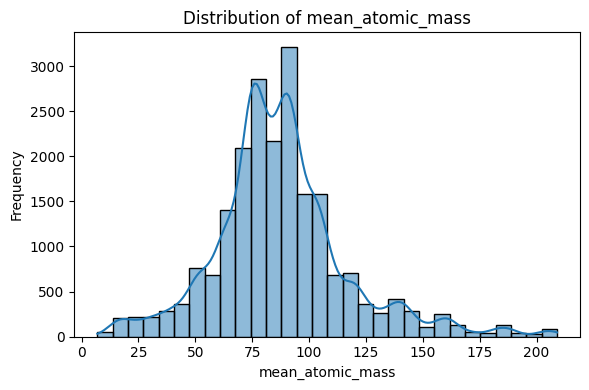

In [17]:
selected_cols = ['critical_temp', 'number_of_elements', 'mean_atomic_mass']
for col in selected_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

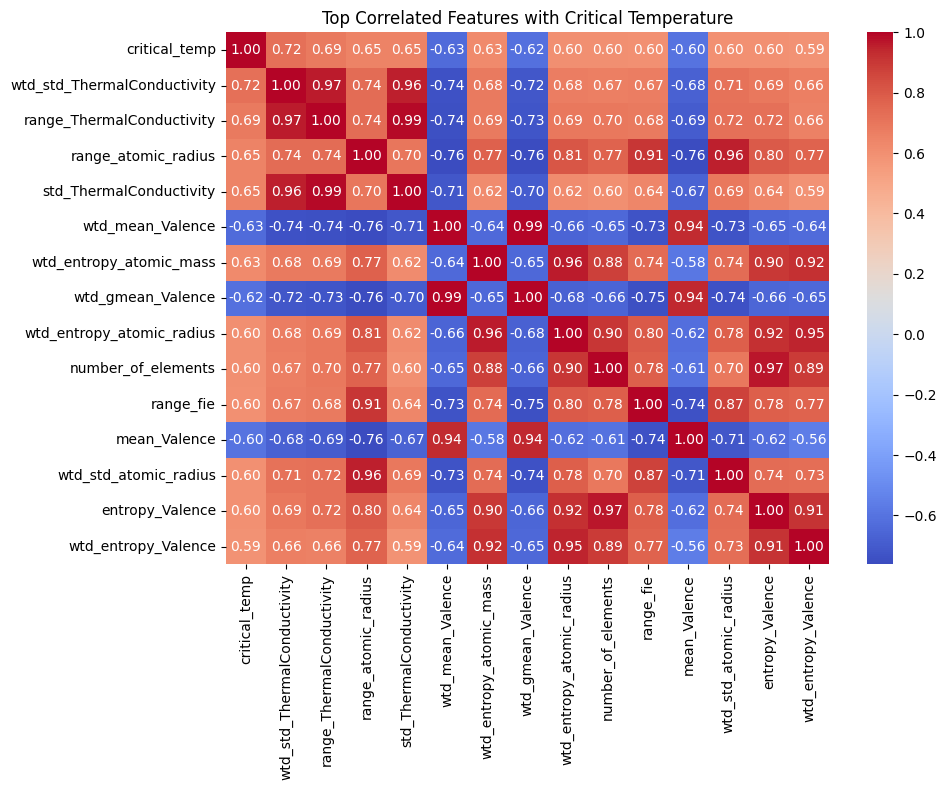

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['critical_temp'].abs().sort_values(ascending=False).head(15).index
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features with Critical Temperature')
plt.tight_layout()
plt.show()

In [19]:
z_scores = np.abs(zscore(df['critical_temp']))
outliers = df[z_scores > 3]
print(f"\nNumber of outliers in 'critical_temp' (z-score > 3): {len(outliers)}")



Number of outliers in 'critical_temp' (z-score > 3): 4


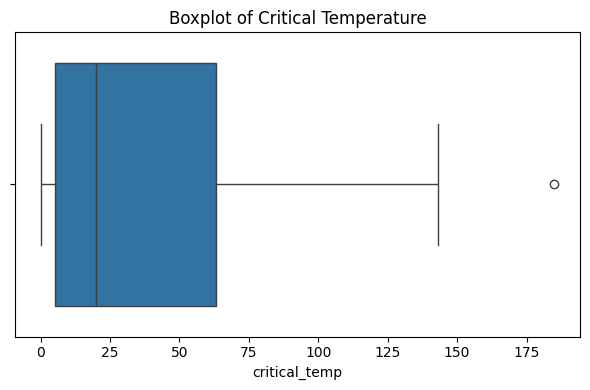

In [20]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['critical_temp'])
plt.title('Boxplot of Critical Temperature')
plt.tight_layout()
plt.show()


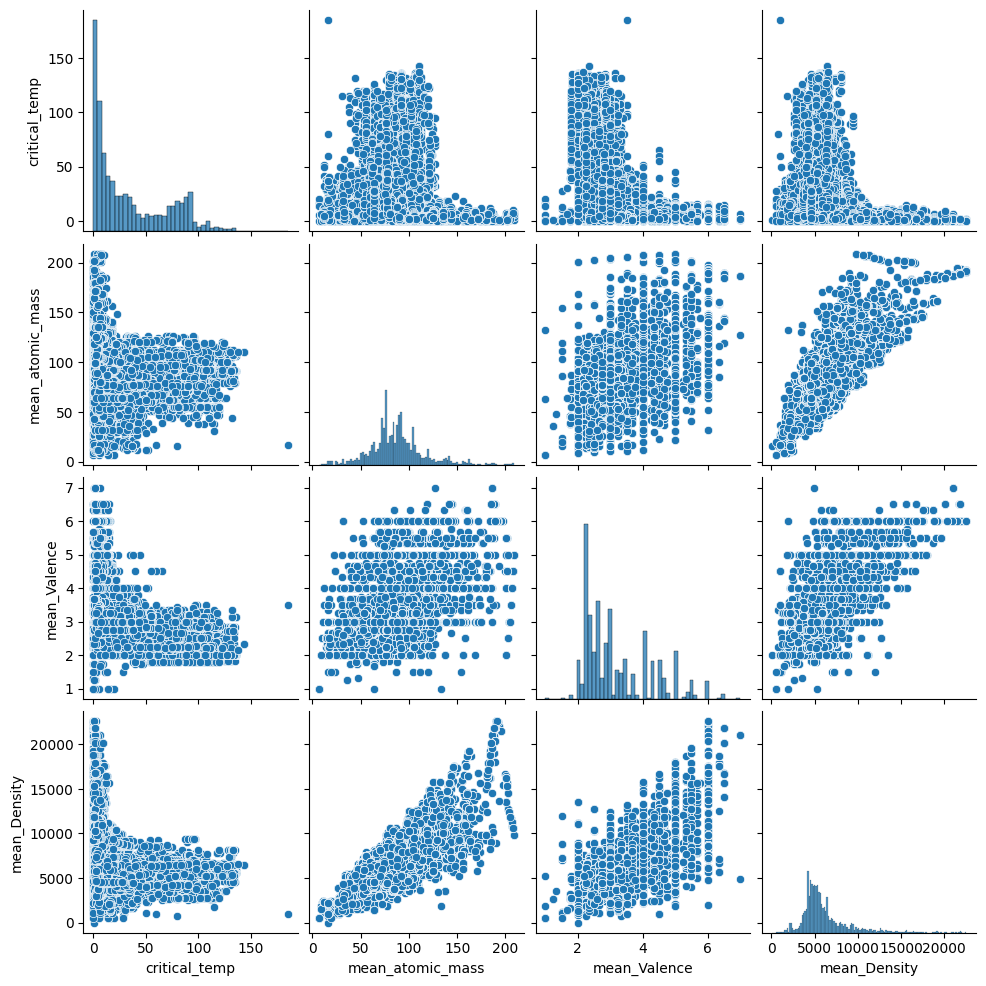

In [21]:
selected = ['critical_temp', 'mean_atomic_mass', 'mean_Valence', 'mean_Density']
sns.pairplot(df[selected])
plt.show()

<b>Q.</b> Does the average valence electron concentration in superconducting materials exhibit a characteristic peak or optimal range that maximizes the critical temperature, consistent with Matthias' empirical correlation?

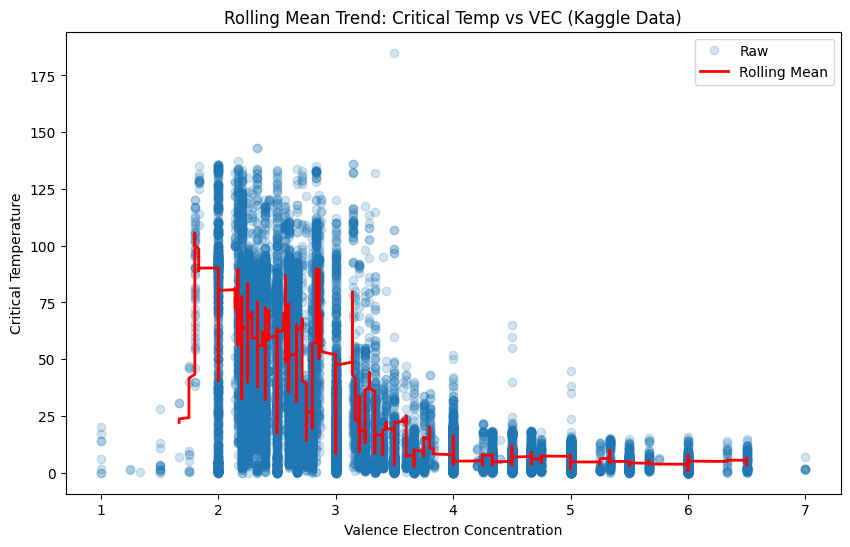

In [234]:
df_sorted = df.sort_values('mean_Valence')
rolling_window = 50
rolling_mean = df_sorted['critical_temp'].rolling(window=rolling_window, center=True).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_sorted['mean_Valence'], df_sorted['critical_temp'], 'o', alpha=0.2, label='Raw')
plt.plot(df_sorted['mean_Valence'], rolling_mean, color='red', linewidth=2, label='Rolling Mean')
plt.xlabel("Valence Electron Concentration")
plt.ylabel("Critical Temperature")
plt.title("Rolling Mean Trend: Critical Temp vs VEC (Kaggle Data)")
plt.legend()
plt.show()


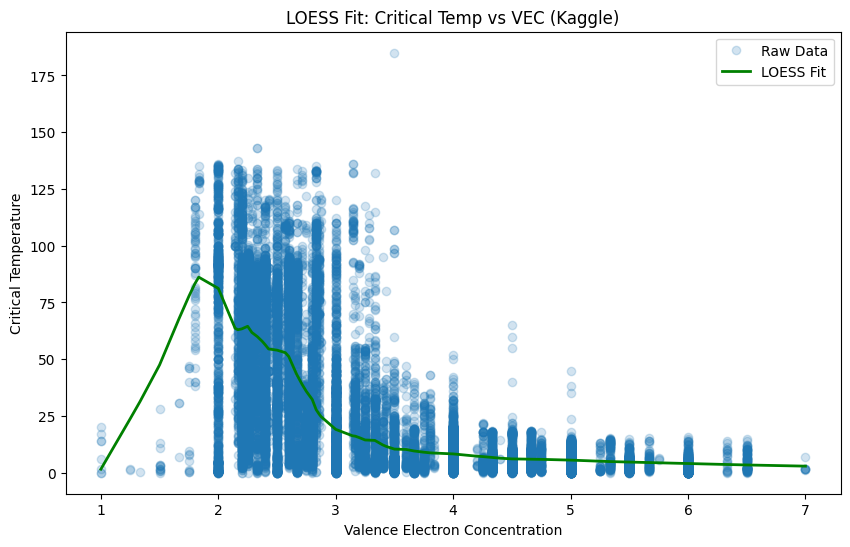

In [244]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess
z = lowess(df['critical_temp'], df['mean_Valence'], frac=0.2)

plt.figure(figsize=(10, 6))
plt.plot(df['mean_Valence'], df['critical_temp'], 'o', alpha=0.2, label='Raw Data')
plt.plot(z[:, 0], z[:, 1], color='green', linewidth=2, label='LOESS Fit')
plt.xlabel("Valence Electron Concentration")
plt.ylabel("Critical Temperature")
plt.title("LOESS Fit: Critical Temp vs VEC (Kaggle)")
plt.legend()
plt.show()


### Observations :
- Peak Behavior is when VEC is around 2–2.5. <br>
- This region also corresponds to higher critical temperatures, peaking around 75–125 K. <br>
- As VEC increases beyond 3, there's a noticeable decline in both the density of high critical_temp values and the max values of critical_temp themselves

This observation supports Matthias’ empirical correlation : Matthias suggested that certain valence electron concentrations lead to maximal superconducting temperatures.

<b> Q. </b> What kind of machine learning model performs best in predicting the critical temperature of superconducting materials based on physicochemical descriptors?

In [22]:
df[top_corr].columns

Index(['critical_temp', 'wtd_std_ThermalConductivity',
       'range_ThermalConductivity', 'range_atomic_radius',
       'std_ThermalConductivity', 'wtd_mean_Valence',
       'wtd_entropy_atomic_mass', 'wtd_gmean_Valence',
       'wtd_entropy_atomic_radius', 'number_of_elements', 'range_fie',
       'mean_Valence', 'wtd_std_atomic_radius', 'entropy_Valence',
       'wtd_entropy_Valence'],
      dtype='object')

In [23]:
# considering only the most correlated features
X = df[top_corr]
y = df["critical_temp"]

In [24]:
# splitting the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# scaling the data to ensure that all features are on a comparable scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<b>Using Linear Regression to predict critical temperature</b>

In [27]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

LinearRegression()

In [28]:
y_pred = model_lr.predict(X_test_scaled)

In [29]:
y_pred[:5]

array([ 6.63032976, 92.4453199 , 38.60855722, 19.38114197, 11.28538818])

In [30]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Root Mean Squared Error: 0.692030227481974
R² Score: 0.9995839510312992


<b>Using Neural Network to predict critical temperature</b>

In [32]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [33]:
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [34]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [35]:
# Define the model
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [36]:
model = RegressionNN(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Early stopping parameters
patience = 10
best_val_loss = np.inf
early_stop_counter = 0
train_losses, val_losses = [], []

In [38]:
for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            epoch_val_loss += val_loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss = 529.1954, Val Loss = 41.0337
Epoch 2: Train Loss = 102.5399, Val Loss = 13.9698
Epoch 3: Train Loss = 85.6763, Val Loss = 4.1001
Epoch 4: Train Loss = 76.3743, Val Loss = 6.3116
Epoch 5: Train Loss = 77.2759, Val Loss = 8.1687
Epoch 6: Train Loss = 76.7019, Val Loss = 6.7327
Epoch 7: Train Loss = 72.9113, Val Loss = 3.4763
Epoch 8: Train Loss = 74.1435, Val Loss = 3.3783
Epoch 9: Train Loss = 69.8042, Val Loss = 1.8869
Epoch 10: Train Loss = 69.4207, Val Loss = 1.8396
Epoch 11: Train Loss = 67.3443, Val Loss = 2.0373
Epoch 12: Train Loss = 66.3372, Val Loss = 13.7836
Epoch 13: Train Loss = 65.1998, Val Loss = 1.5048
Epoch 14: Train Loss = 65.4062, Val Loss = 4.7682
Epoch 15: Train Loss = 63.5713, Val Loss = 1.3323
Epoch 16: Train Loss = 62.6793, Val Loss = 8.4904
Epoch 17: Train Loss = 60.5991, Val Loss = 1.7932
Epoch 18: Train Loss = 60.5767, Val Loss = 1.0011
Epoch 19: Train Loss = 58.7999, Val Loss = 4.8384
Epoch 20: Train Loss = 59.4011, Val Loss = 2.2363
Epoc

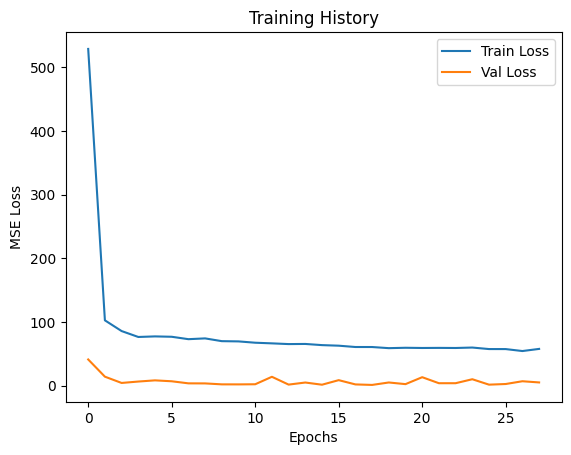

In [39]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Plot training history
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [40]:
# Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

In [41]:
# Evaluation
output = pd.DataFrame(y_test)
output["predicted"] = predictions

In [42]:
rmse = root_mean_squared_error(output['critical_temp'], output['predicted'])
r2 = r2_score(output['critical_temp'], output['predicted'])
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Root Mean Squared Error: 1.250329283805294
R² Score: 0.9986418644217221


# NOTES / EXPERIMENTING

Why does lr work better than nn? <br>
If the relationship between the input features and the target (critical_temp) is approximately linear, then a linear model will:
- Learn faster
- Generalize better
- Require fewer parameters
- Be less prone to overfitting

Feature engineering here also favours linear models, because stuff like weighted mean, std, and entropy allow linear regression models to work significantly better as they make the data 

### trying to use PCA instead of dropping columns that are irrelevant
just in case this accuracy isnt good enough, we could try to use pca to reduce dimensionality instead of simply dropping other columns
DID NOT WORK